# Modeling - Regression

What is it?
-  a SUPERVISED machine learning model used to predict a CONTINUOUS target variable

Why do we care?
- so we can build models to predict future continuous target variables

### Pipeline

Acquire

Wrangle

Explore 

Model 


### Models today
- Ordinary Least Squares
- LASSO + LARS
- Polynomial Regression
- Generalized Linear Model

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Scenario

Continuing with attempting to predict final exam grade based on previous exam grades
    
    

## Wrangle

In [4]:
def wrangle_grades():
    '''
    read csv from url into df, clean df, and return the prepared df
    '''
    # Read csv file into pandas DataFrame.
    file = "https://gist.githubusercontent.com/ryanorsinger/\
14c8f919920e111f53c6d2c3a3af7e70/raw/07f6e8004fa171638d6d599cfbf0513f6f60b9e8/student_grades.csv"
    df = pd.read_csv(file)


    
    #replace blank space with null value
    df.exam3 = df.exam3.replace(' ', np.nan)
    
    #drop all nulls
    df = df.dropna()
    
    # Convert all columns to int64 data types.
    df = df.astype('int')

    # Perform a train, validate, test split
    train_validate, test = train_test_split(df, random_state=123, train_size=.8)
    train, validate = train_test_split(train_validate, random_state=123, train_size=.7)
    
    return train, validate, test

In [5]:
train, validate, test = wrangle_grades() 

In [6]:
train.head()

,student_id,exam1,exam2,exam3,final_grade
51,52,70,75,78,72
24,25,57,65,75,65
57,58,79,70,85,81
92,93,98,93,96,95
81,82,83,80,86,85


## Model - Regression Edition

Split into our X_train and y_train using our numeric data

#### plot the target variable

## Baseline

#### evaluate

In [58]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [7]:
#make an array to send into my mean_square_error function


In [61]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])

,model,rmse,r2
0,baseline,10.410439,0.0


## Ordinary Least Squares (OLS)

OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

In [8]:
#import


### simple linear regression + RFE

send in only one feature

#### find the best feature

In [9]:
#intial ML model


#make it

#fit it

#use it on train

#use it on validate


In [10]:
print('selected top feature:', rfe.get_feature_names_out())

NameError: name 'rfe' is not defined

#### build model from top feature

In [78]:
#fit the thing

#use the thing (make predictions)


#### evaluate

In [11]:
#train


In [12]:
#validate


In [13]:
#add to my metrics df


### examine the model
   
$y = \beta_0 + \beta_i x_i$

**intercept** ($\beta_0$): Value we predict if x is 0. Depending on our x variables, this may not be valuable

**coefficients** ($\beta_i$): Define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a coef unit change in y, holding all other independent variables constant

In [14]:
# print(f'final_grade = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*exam1')

In [15]:
# plt.figure(figsize=(4, 4))

# plt.scatter(train.exam1, train.final_grade)

# #build prediction line from intercept and slope
# x_val = np.array([-2, 100]).reshape(-1, 1)
# plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

# #intercept line
# plt.hlines(22, -5, 100, ls=':', color='red')  

# #(0,0) axis
# plt.hlines(0, -5, 100, ls='--', color='grey')
# plt.vlines(0, -10, 100, ls='--', color='grey')
 
# plt.xlabel('Exam 1')
# plt.ylabel('Final Grade')
# plt.show()

#### Intrepretation

For every 1 [unit] increase in [feature], we predict a [# unit] increase in [target_variable]

In [16]:
# print(f'For every 1 point increase in Exam 1, we predict a {lr1.coef_[0]:.2f} point increase in Final Grade')

### Multiple Regression

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$

#### model using OLS

In [17]:
#make it

#fit it on our RFE features

#use it (make predictions)

#use it on validate


#### evaluate

In [19]:
#train 


In [20]:
#validate


In [21]:
#add to my metrics df


## LassoLars

LASSO = Least Absolute Shrinkage and Selection Operator

LARS = Least Angle Regression

- Performs intrinsic feature selection and noise reduction to avoid overfitting
- The most important hyperparameter is alpha
    - alpha determines the degree of regularization applied to the model
    - The lowest alpha is zero, and this represents no regularization (identical to OLS)
    - There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    - Generally speaking, the higher the alpha, the lower your risk for overfitting
    - alpha = 1.0 is a good place to start

In [23]:
#import


#### alpha = 0, identical to OLS

In [24]:
#make it

#fit it

#use it


#### alpha = 1 

In [25]:
#make it

#fit it

#use it


#### evaluate

In [103]:
#train


(1.6026392529668225, 0.9763008103790245)

In [26]:
#validate


In [27]:
#add to my metrics df


## Polynomial Regression

$y = \beta_0 + \beta_i x + \beta_k x^k$

We can introduce higher powers of our independent variables, meaning the model can predict a curve instead of a line 

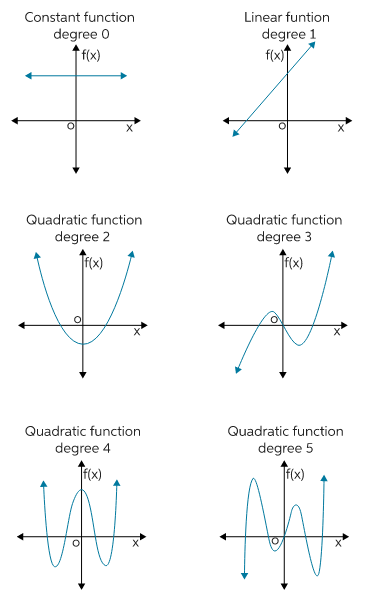

However, the more curves you introduce, the more likely your model is to be overfit!

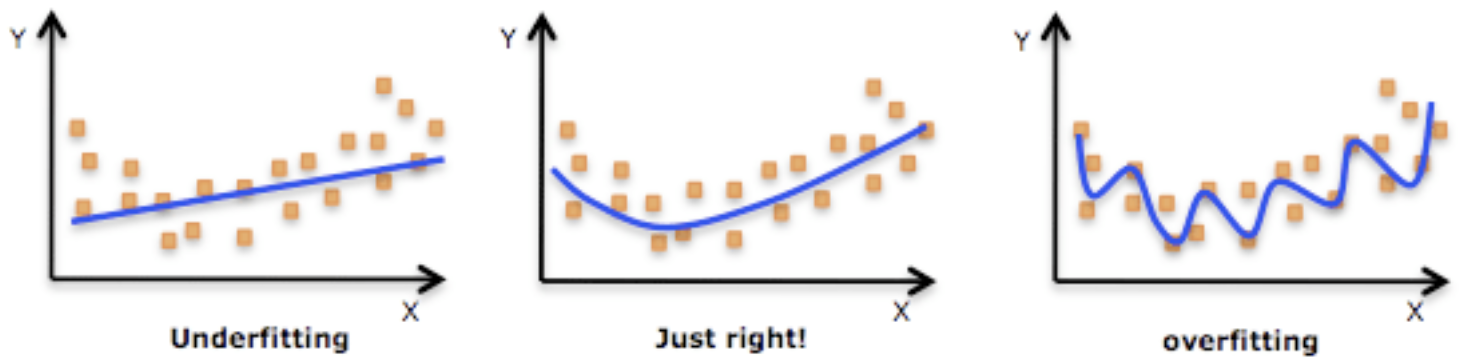

#### process
1. create new features based on degrees
2. fit on a linear regression model

In [28]:
#import


#### create new features based on degrees

In [29]:
# make the polynomial features to get a new set of features

# fit and transform X_train_scaled

# transform X_validate_scaled & X_test_scaled


#### fit on a linear regression model

In [30]:
#make it

#fit it

#use it


#### evaluate

In [32]:
#train


In [33]:
#validate


In [34]:
#add to my metrics df


## Generalized Linear Model (GLM)

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:

    power = 0: Normal Distribution
    power = 1: Poisson Distribution
    power = (1,2): Compound Distribution
    power = 2: Gamma Distribution
    power = 3: Inverse Gaussian Distribution

In [37]:
#import


In [38]:
#make it

#fit it

#use it


#### evaluate

In [39]:
#train


In [40]:
#validate


### Evaluate on Best Model

In [41]:
#use it


#### plot actuals vs predicted

In [42]:
# plt.scatter(pred_lr2, y_train, label='linear regression')
# plt.scatter(pred_pr, y_train, label='polynominal 2deg')
# plt.scatter(pred_glm, y_train, label='glm')
# plt.plot(y_train, y_train, label='_nolegend_', color='grey')

# plt.axhline(baseline, ls=':', color='grey')
# plt.annotate("Baseline", (65, 81))

# plt.title("Where are predictions more extreme? More modest?")
# plt.ylabel("Actual Final Grade")
# plt.xlabel("Predicted Final Grade")
# plt.legend()

# plt.show()

#### plotting the residuals

In [43]:
# plt.axhline(label="No Error")

# plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
# plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
# plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

# plt.legend()
# plt.title("Do the size of errors change as the actual value changes?")
# plt.xlabel("Actual Final Grade")
# plt.ylabel("Residual: Predicted Grade - Actual Grade")

# plt.show()

#### histogram of actual and predicted values

In [44]:
# plt.hist(y_train, color='blue', alpha=.5, label="Actual")
# plt.hist(pred_lr2, color='red', alpha=.5, label="LinearRegression")
# plt.hist(pred_glm, color='yellow', alpha=.5, label="TweedieRegressor")
# plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")

# plt.xlabel("Final Grade")
# plt.ylabel("Number of Students")
# plt.title("Comparing the Distribution of Actual to Predicted Grades")
# plt.legend()
# plt.show()

### Recap
